In [ ]:
import os
import pandas as pd
import ast

In [ ]:
# 1. 파일 경로 설정
folder_path = '../../data'
csv_filename = 'test_data_3.csv'
csv_path = os.path.join(folder_path, csv_filename)

# 2. 데이터 불러오기
df = pd.read_csv(csv_path, encoding="utf-8")

# 3. 관객수 리스트 정제 함수
def clean_audience_list(raw):
    try:
        if isinstance(raw, str):
            parsed = ast.literal_eval(raw)
        else:
            parsed = raw
    except:
        return []
    
    result = []
    for val in parsed:
        try:
            num = int(str(val).replace(',', '').strip())
            result.append(num)
        except:
            continue
    return result

# 4. 개선된 흥행 안정성 지수 계산 함수
def enhanced_stability_index(lst, days):
    if len(lst) < days or lst[0] == 0:
        return None

    first = lst[0]
    last = lst[days - 1]
    avg = sum(lst[:days]) / days
    total = sum(lst[:days])

    # 유지력과 감소율
    ratio_avg = avg / first
    ratio_decay = last / first

    # 추세 기울기 (선형 회귀 형태)
    x = list(range(1, days + 1))
    y = lst[:days]
    try:
        slope = (days * sum([a * b for a, b in zip(x, y)]) - sum(x) * sum(y)) / \
                (days * sum([i**2 for i in x]) - sum(x)**2)
    except ZeroDivisionError:
        slope = 0

    # 최종 점수 계산
    base_score = (ratio_avg + ratio_decay) / 2
    scaled = base_score * total
    final_score = scaled * (1 + slope / first)  # 추세가 양의 기울기면 보상

    return round(final_score, 4)

# 5. 흥행 안정성 지수 계산 및 컬럼 추가
df['흥행안정성지수_3일'] = df['관객수'].apply(lambda raw: enhanced_stability_index(clean_audience_list(raw), 3))
df['흥행안정성지수_10일'] = df['관객수'].apply(lambda raw: enhanced_stability_index(clean_audience_list(raw), 10))

# 6. 저장
output_filename = 'data_add_stability_index_3.csv'
output_path = os.path.join(folder_path, output_filename)
df.to_csv(output_path, index=False, encoding='utf-8-sig', float_format='%.4f')

print(f"[✔️ 저장 완료] 개선된 흥행 안정성 지수 포함 파일: {output_path}")


[✔️ 저장 완료] 개선된 흥행 안정성 지수 포함 파일: ../../data\data_with_enhanced_stability_index.csv


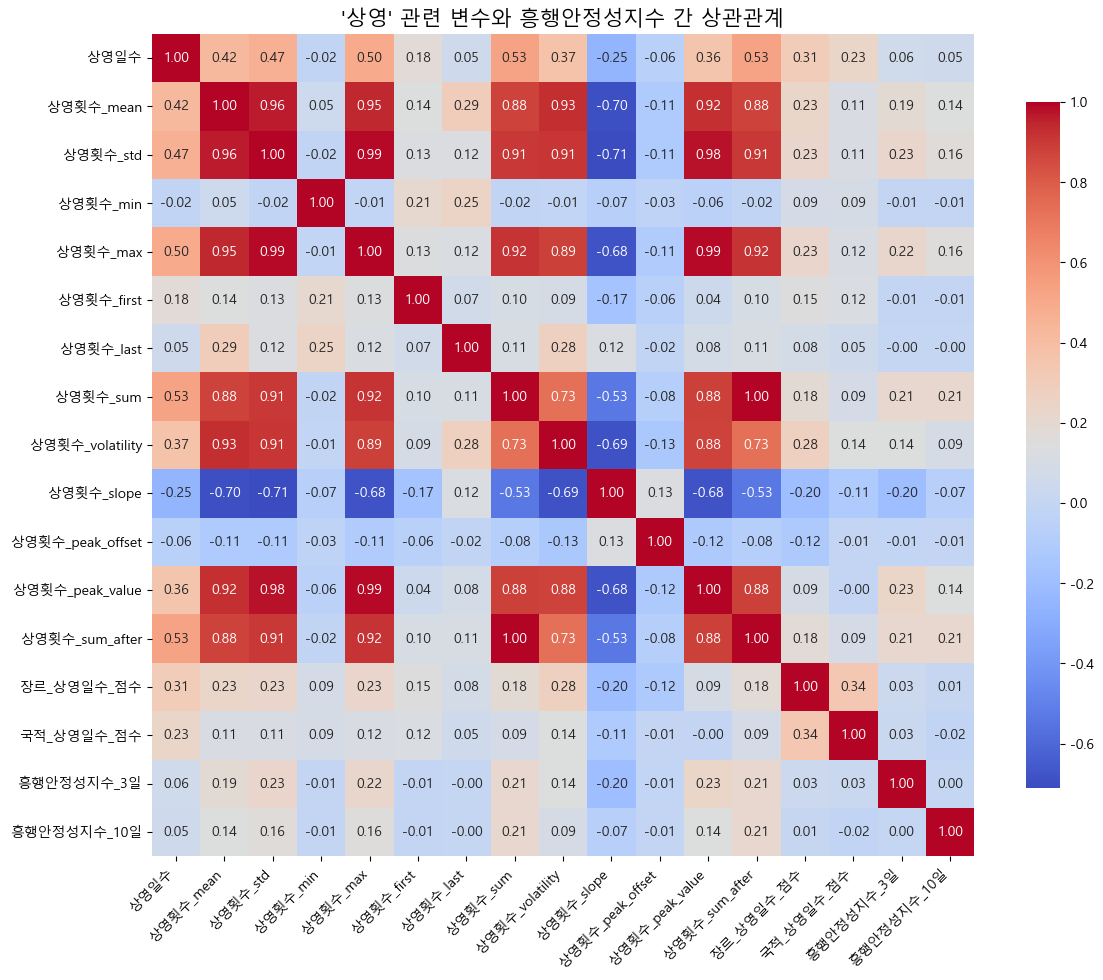

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. 경로 설정 및 데이터 불러오기
folder_path = '../../data'
csv_filename = 'data_with_enhanced_stability_index.csv'
csv_path = os.path.join(folder_path, csv_filename)
df = pd.read_csv(csv_path, encoding='utf-8')

# 2. 수치형 컬럼 중 '상영'이 포함된 컬럼 + 지수 2개 선택
numeric_df = df.select_dtypes(include='number')
screening_cols = [col for col in numeric_df.columns if '상영' in col]
target_cols = ['흥행안정성지수_3일', '흥행안정성지수_10일']
selected_cols = screening_cols + [col for col in target_cols if col in numeric_df.columns]

# 3. 상관행렬 계산
corr_matrix = numeric_df[selected_cols].corr()

# 4. 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("'상영' 관련 변수와 흥행안정성지수 간 상관관계", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
